In [1]:
import pandas as pd

# Đường dẫn file
file_path = r"E:\pt Chuỗi thời gian\data1\Data1.csv"

# Kích thước mỗi chunk
chunk_size = 100000

# Sử dụng engine='python' để tránh lỗi out of memory
chunk_id = 0
for chunk in pd.read_csv(file_path, sep=';', chunksize=chunk_size, engine='python', on_bad_lines='skip', encoding='utf-8'):
    chunk_id += 1
    print(f"Đang xử lý chunk {chunk_id} với shape: {chunk.shape}")
    
    # Xử lý dữ liệu ở đây (ví dụ: chỉ in ra 5 dòng đầu)
    print(chunk.head())

print("✅ Đã xử lý xong toàn bộ file CSV.")


Đang xử lý chunk 1 với shape: (100000, 4)
       LCLid stdorToU             DateTime  KWH/hh (per half hour)
0  MAC000002      Std  2012-01-11 00:00:00              250.059031
1  MAC000002      Std  2012-01-11 00:30:00              241.032028
2  MAC000002      Std  2012-01-11 01:00:00               23.116147
3  MAC000002      Std  2012-01-11 01:30:00              208.274767
4  MAC000002      Std  2012-01-11 02:00:00              225.647851
Đang xử lý chunk 2 với shape: (100000, 4)
            LCLid stdorToU             DateTime  KWH/hh (per half hour)
100000  MAC000002      Std  2014-01-05 06:00:00              109.300461
100001  MAC000002      Std  2014-01-05 06:30:00               98.878634
100002  MAC000002      Std  2014-01-05 07:00:00               94.352594
100003  MAC000002      Std  2014-01-05 07:30:00              113.434800
100004  MAC000002      Std  2014-01-05 08:00:00               83.703902
Đang xử lý chunk 3 với shape: (100000, 4)
            LCLid stdorToU             D

In [2]:
import pandas as pd

file_path = r"E:/pt Chuỗi thời gian/data1/Data1.csv"
chunk_size = 100_000

unique_ids = set()
for chunk in pd.read_csv(file_path, sep=';', usecols=["LCLid"], chunksize=chunk_size,
                         engine='python', on_bad_lines='skip', encoding='utf-8'):
    unique_ids.update(chunk["LCLid"].dropna().unique())

unique_ids = list(unique_ids)
print(f"✅ Tổng số hộ gia đình tìm được: {len(unique_ids)}")



✅ Tổng số hộ gia đình tìm được: 4001


In [3]:
from collections import defaultdict
import pandas as pd

file_path = r"E:/pt Chuỗi thời gian/data1/Data1.csv"
chunk_size = 100_000

# Đọc lại danh sách hộ nếu cần
unique_ids = set()
for chunk in pd.read_csv(file_path, sep=';', usecols=["LCLid"], chunksize=chunk_size,
                         engine='python', on_bad_lines='skip', encoding='utf-8'):
    unique_ids.update(chunk["LCLid"].dropna().unique())
unique_ids = list(unique_ids)

# Chọn số hộ cần lấy (ví dụ 20 đầu tiên)
target_ids = set(unique_ids[:20])  # <= KHÔNG nên lấy 50 cùng lúc

# Dùng defaultdict để gom lại
customer_data = defaultdict(list)

# Chỉ đọc file đúng 1 lần
for chunk in pd.read_csv(file_path, sep=';', chunksize=chunk_size,
                         engine='python', on_bad_lines='skip', encoding='utf-8'):
    chunk = chunk[chunk["LCLid"].isin(target_ids)]
    for cust_id, group in chunk.groupby("LCLid"):
        customer_data[cust_id].append(group)

# Ghép các phần lại thành từng DataFrame
for cust_id in customer_data:
    customer_data[cust_id] = pd.concat(customer_data[cust_id])

print(f"✅ Đã đọc được dữ liệu cho {len(customer_data)} hộ.")



✅ Đã đọc được dữ liệu cho 20 hộ.


In [4]:
processed_data = {}

for customer_id, df_cust in customer_data.items():
    try:
        df_cust.dropna(subset=["KWH/hh (per half hour)", "DateTime"], inplace=True)
        df_cust["DateTime"] = pd.to_datetime(df_cust["DateTime"], dayfirst=True)
        df_cust = df_cust.sort_values("DateTime")
        df_cust.set_index("DateTime", inplace=True)

        y = df_cust["KWH/hh (per half hour)"].astype(float).resample("30min").mean().fillna(method="ffill")

        if len(y) >= 200:
            processed_data[customer_id] = y

    except Exception as e:
        print(f"Lỗi với {customer_id}: {e}")


C:\Users\ASUS\AppData\Local\Temp\ipykernel_20864\3728842564.py:6: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df_cust["DateTime"] = pd.to_datetime(df_cust["DateTime"], dayfirst=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_20864\3728842564.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = df_cust["KWH/hh (per half hour)"].astype(float).resample("30min").mean().fillna(method="ffill")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_20864\3728842564.py:6: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df_cust["DateTime"] = pd.to_datetime(df_cust["DateTime"], dayfirst=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_20864\3728842564.py:10: FutureWarning: Series.fillna with 'me

Lỗi với MAC000577: time data "2012-04-13 00:00:00" doesn't match format "%Y-%d-%m %H:%M:%S", at position 72. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.
Lỗi với MAC001011: time data "2012-05-13 00:00:00" doesn't match format "%Y-%d-%m %H:%M:%S", at position 409. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.
Lỗi với MAC001015: time data "2012-05-13 00:00:00" doesn't match format "%Y-%d-%m %H:%M:%S"

C:\Users\ASUS\AppData\Local\Temp\ipykernel_20864\3728842564.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = df_cust["KWH/hh (per half hour)"].astype(float).resample("30min").mean().fillna(method="ffill")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_20864\3728842564.py:6: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df_cust["DateTime"] = pd.to_datetime(df_cust["DateTime"], dayfirst=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_20864\3728842564.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = df_cust["KWH/hh (per half hour)"].astype(float).resample("30min").mean().fillna(method="ffill")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_20864\3728842564.py:6: UserWarning: Parsing dates in %Y-

Lỗi với MAC004031: time data "2012-07-13 00:00:00" doesn't match format "%Y-%d-%m %H:%M:%S", at position 312. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.
Lỗi với MAC004736: time data "2012-04-13 00:00:00" doesn't match format "%Y-%d-%m %H:%M:%S", at position 506. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.
Lỗi với MAC004826: time data "2012-04-13 00:00:00" doesn't match format "%Y-%d-%m %H:%M:%S

C:\Users\ASUS\AppData\Local\Temp\ipykernel_20864\3728842564.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = df_cust["KWH/hh (per half hour)"].astype(float).resample("30min").mean().fillna(method="ffill")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_20864\3728842564.py:6: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df_cust["DateTime"] = pd.to_datetime(df_cust["DateTime"], dayfirst=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_20864\3728842564.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = df_cust["KWH/hh (per half hour)"].astype(float).resample("30min").mean().fillna(method="ffill")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_20864\3728842564.py:6: UserWarning: Parsing dates in %Y-

In [7]:
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

results = []

for customer_id, y in processed_data.items():
    try:
        print(f"\n🔍 Huấn luyện ARIMA cho hộ {customer_id}...")

        # Chia train/test
        split = int(len(y) * 0.8)
        train, test = y[:split], y[split:]

        # Tìm tham số tốt nhất tự động
        model = auto_arima(train,
                           seasonal=False,
                           stepwise=True,
                           suppress_warnings=True,
                           error_action='ignore',
                           max_order=None,  # không giới hạn (p,d,q)
                           trace=False)

        # Dự báo
        forecast = model.predict(n_periods=len(test))

        # Đánh giá
        mae = mean_absolute_error(test, forecast)
        rmse = np.sqrt(mean_squared_error(test, forecast))

        print(f"✅ MAE: {mae:.3f} | RMSE: {rmse:.3f} | Order: {model.order}")

        # Ghi kết quả
        results.append({
            "LCLid": customer_id,
            "MAE": mae,
            "RMSE": rmse,
            "Order": model.order
        })

    except Exception as e:
        print(f"❌ Lỗi với {customer_id}: {e}")



🔍 Huấn luyện ARIMA cho hộ MAC000426...


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprec

✅ MAE: 0.201 | RMSE: 0.313 | Order: (1, 1, 4)

🔍 Huấn luyện ARIMA cho hộ MAC001395...


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprec

✅ MAE: 0.412 | RMSE: 0.563 | Order: (1, 1, 3)

🔍 Huấn luyện ARIMA cho hộ MAC002198...


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprec

✅ MAE: 0.096 | RMSE: 0.149 | Order: (1, 0, 5)

🔍 Huấn luyện ARIMA cho hộ MAC003852...


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprec

✅ MAE: 0.252 | RMSE: 0.348 | Order: (3, 1, 3)

🔍 Huấn luyện ARIMA cho hộ MAC004122...


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprec

✅ MAE: 0.030 | RMSE: 0.089 | Order: (0, 1, 3)

🔍 Huấn luyện ARIMA cho hộ MAC004310...


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprec

✅ MAE: 0.033 | RMSE: 0.070 | Order: (3, 1, 1)

🔍 Huấn luyện ARIMA cho hộ MAC004576...


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprec

✅ MAE: 0.445 | RMSE: 0.569 | Order: (1, 1, 3)

🔍 Huấn luyện ARIMA cho hộ MAC005008...


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprec

✅ MAE: 0.412 | RMSE: 0.545 | Order: (0, 1, 3)

🔍 Huấn luyện ARIMA cho hộ MAC005018...


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprec

✅ MAE: 0.123 | RMSE: 0.148 | Order: (1, 1, 3)

🔍 Huấn luyện ARIMA cho hộ MAC005132...


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprec

✅ MAE: 0.064 | RMSE: 0.092 | Order: (4, 0, 4)


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprec

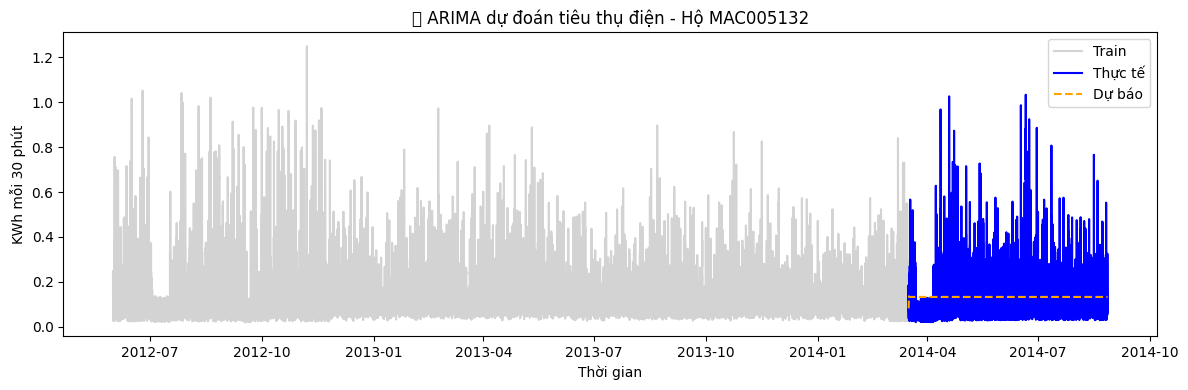

In [9]:
import matplotlib.pyplot as plt
# Cập nhật lại chỉ số thời gian nếu cần
y.index = pd.to_datetime(y.index)

# Chia train/test
split = int(len(y) * 0.8)
train, test = y[:split], y[split:]

# Fit mô hình ARIMA
model = auto_arima(train, seasonal=False, suppress_warnings=True)
forecast = model.predict(n_periods=len(test))

# Tạo index tương ứng cho forecast
forecast_index = test.index

# Vẽ
plt.figure(figsize=(12, 4))
plt.plot(train.index, train, label="Train", color="lightgray")
plt.plot(test.index, test, label="Thực tế", color="blue")
plt.plot(forecast_index, forecast, label="Dự báo", color="orange", linestyle="--")
plt.title(f"📈 ARIMA dự đoán tiêu thụ điện - Hộ {customer_id}")
plt.xlabel("Thời gian")
plt.ylabel("KWh mỗi 30 phút")
plt.legend()
plt.tight_layout()
plt.show()


In [18]:

# 🧩 Import thư viện
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pmdarima import auto_arima
import warnings
import time

warnings.filterwarnings("ignore")

# ✅ Định nghĩa hàm dự đoán
def dudoan_arima_theo_ho(df_cust, customer_id, max_data_points=5000):
    print(f"\n🔍 Huấn luyện ARIMA cho hộ {customer_id}...")

    # Tiền xử lý dữ liệu
    y = df_cust['KWH/hh (per half hour)'].dropna()
    y = y[-max_data_points:]  # Chỉ lấy phần cuối nếu quá nhiều dữ liệu

    if not isinstance(y.index, pd.DatetimeIndex):
        y.index = pd.to_datetime(y.index)

    # Chia train / test
    split = int(len(y) * 0.8)
    train, test = y[:split], y[split:]

    # Huấn luyện ARIMA
    start = time.time()
    model = auto_arima(train, seasonal=False, suppress_warnings=True,
                       max_p=3, max_q=3, max_d=2, max_order=7,
                       stepwise=True, error_action='ignore')
    duration = time.time() - start

    # Dự báo
    forecast = model.predict(n_periods=len(test))

    # Tính MAE, RMSE
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))

    print(f"✅ MAE: {mae:.3f} | RMSE: {rmse:.3f} | Order: {model.order} | ⏱️ Thời gian: {duration:.1f}s")

    # Vẽ biểu đồ
       # Vẽ biểu đồ kiểu liền mạch
    plt.figure(figsize=(12, 4))
    plt.plot(train.index, train, label="Train", color="lightgray")
    plt.plot(test.index, test, label="Actual", color="steelblue")
    plt.plot(test.index, forecast, label="Forecast", color="red", linestyle="--")
    
    # Giao diện và nhãn
    plt.title(f"🔮 Dự báo ARIMA - Hộ {customer_id}")
    plt.xlabel("Thời gian")
    plt.ylabel("KWh mỗi 30 phút")
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()


    return mae, rmse, model.order


In [20]:
# Loại bỏ các giá trị NaN (nếu không nhiều lắm)
y = df_cust['KWH/hh (per half hour)'].dropna()

# Hoặc điền giá trị thiếu bằng giá trị gần nhất trước đó
# y = df_cust['KWH/hh (per half hour)'].fillna(method='ffill')

# Hoặc điền giá trị thiếu bằng giá trị trung bình
# y = df_cust['KWH/hh (per half hour)'].fillna(y.mean())

# Sau đó gọi auto_arima
model = auto_arima(
    y,
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    trace=True
)
print("Best ARIMA order:", model.order)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=107.64 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-98545.412, Time=15.39 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-103453.403, Time=5.60 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-108167.179, Time=9.66 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-98547.412, Time=3.59 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=50.65 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-112298.223, Time=21.27 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=81.61 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-113778.660, Time=59.01 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-114988.102, Time=76.59 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-116404.039, Time=96.73 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=120.94 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=113.02 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-114041.464, Time=85.87 sec
 ARIMA(3,1,2)(0,0,0

In [28]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Tạo chỉ số thời gian (giả sử bắt đầu từ '2020-01-01' và tần suất 30 phút)
n_samples = len(df_cust)
start_date = '2020-01-01'
date_rng = pd.date_range(start=start_date, periods=n_samples, freq='30min')

# Gán chỉ số thời gian
df_cust.index = date_rng

# Dữ liệu để huấn luyện
y = df_cust['KWH/hh (per half hour)']

# Huấn luyện mô hình ARIMA
model = ARIMA(y, order=(2,1,3))
model_fit = model.fit()

# In kết quả
print(model_fit.summary())

# Dự báo 10 bước tiếp theo
forecast = model_fit.forecast(steps=10)
print(forecast)

                                 SARIMAX Results                                  
Dep. Variable:     KWH/hh (per half hour)   No. Observations:                72584
Model:                     ARIMA(2, 1, 3)   Log Likelihood               58293.920
Date:                    Fri, 20 Jun 2025   AIC                        -116575.839
Time:                            15:26:24   BIC                        -116520.685
Sample:                        01-01-2020   HQIC                       -116558.857
                             - 02-21-2024                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3102      0.021    -14.743      0.000      -0.351      -0.269
ar.L2          0.6159      0.013     47.863      0.000       0.591       0.641
ma.L1         -0.165

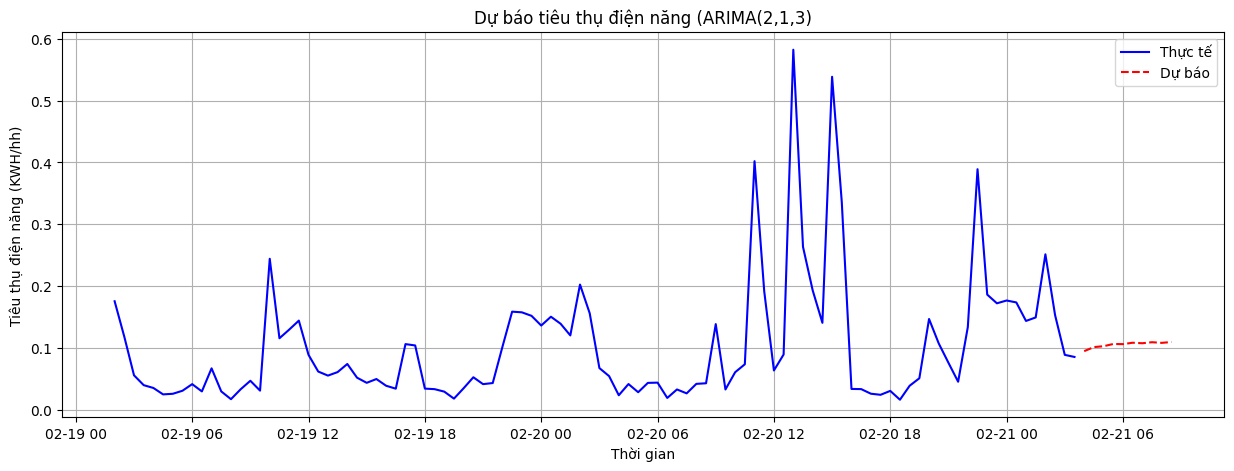

In [30]:
import matplotlib.pyplot as plt

# Lấy khoảng dữ liệu cần hiển thị (10 giá trị cuối cùng và 10 giá trị dự báo)
plt.figure(figsize=(15, 5))
plt.plot(y.index[-100:], y[-100:], label='Thực tế', color='blue')
plt.plot(forecast.index, forecast, label='Dự báo', color='red', linestyle='--')
plt.xlabel('Thời gian')
plt.ylabel('Tiêu thụ điện năng (KWH/hh)')
plt.title('Dự báo tiêu thụ điện năng (ARIMA(2,1,3)')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
from statsmodels.tsa.arima.model import ARIMA

# Giả sử 'y' là chuỗi thời gian gốc
model = ARIMA(y, order=(2, 1, 2))
model_fit = model.fit()


In [24]:
# Dự báo lại quá khứ (in-sample prediction)
fitted = model_fit.predict(start=y.index[1], end=y.index[-1], typ='levels')


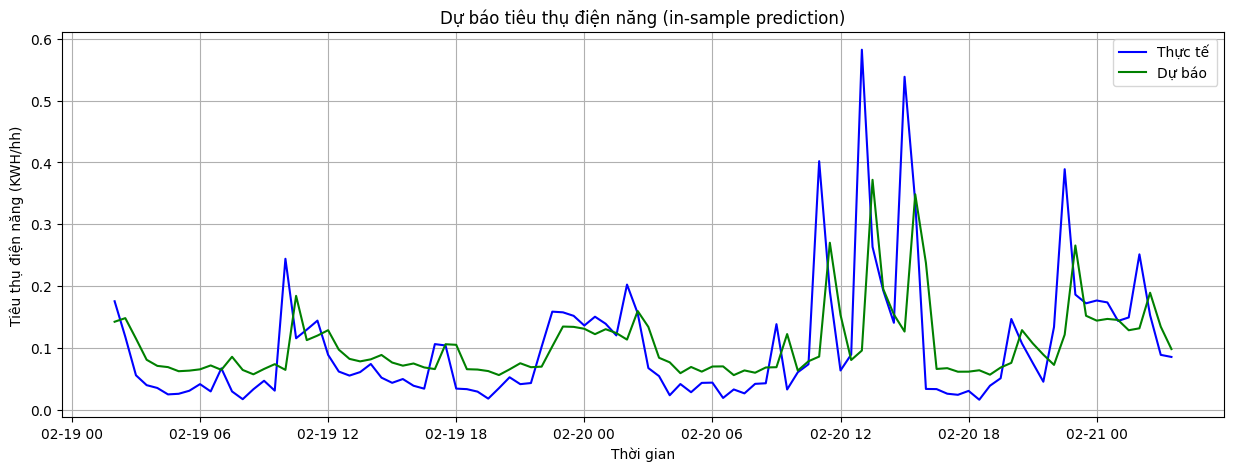

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Vẽ giá trị thực tế
plt.plot(y.index[-100:], y[-100:], label='Thực tế', color='blue')

# Vẽ giá trị dự báo lại trong quá khứ (in-sample forecast)
plt.plot(fitted.index[-100:], fitted[-100:], label='Dự báo ', color='green')

plt.xlabel('Thời gian')
plt.ylabel('Tiêu thụ điện năng (KWH/hh)')
plt.title('Dự báo tiêu thụ điện năng (in-sample prediction)')
plt.legend()
plt.grid(True)
plt.show()


In [26]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# So khớp và loại bỏ NaN
df_compare = pd.DataFrame({
    'y': y[1:],          # Tránh lệch chỉ số so với fitted
    'fitted': fitted
}).dropna()

# Tính MAE và RMSE
mae = mean_absolute_error(df_compare['y'], df_compare['fitted'])
rmse = np.sqrt(mean_squared_error(df_compare['y'], df_compare['fitted']))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 0.06
RMSE: 0.11


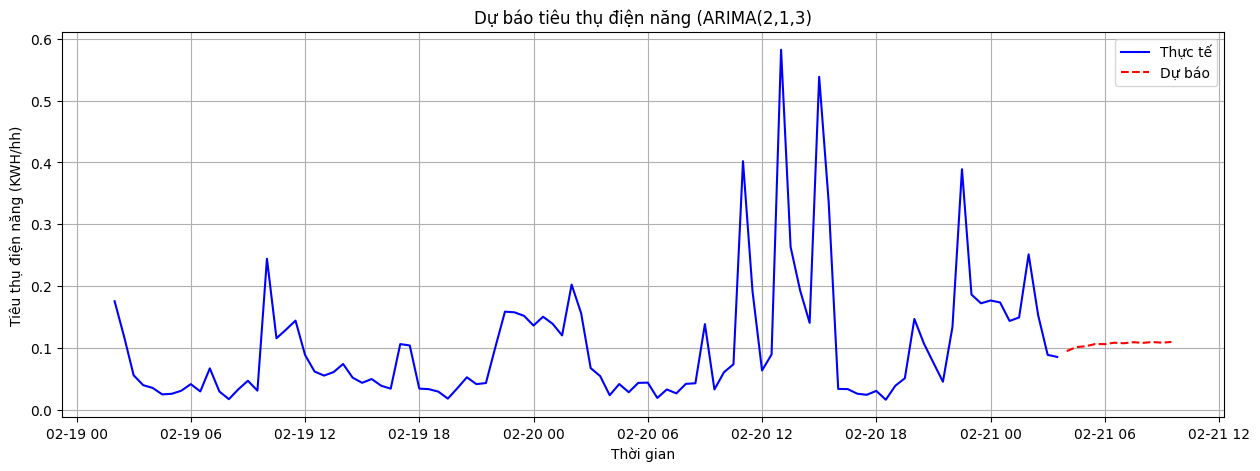

In [35]:
import matplotlib.pyplot as plt

# Lấy khoảng dữ liệu cần hiển thị (10 giá trị cuối cùng và 10 giá trị dự báo)
plt.figure(figsize=(15, 5))
plt.plot(y.index[-100:], y[-100:], label='Thực tế', color='blue')
plt.plot(forecast.index, forecast, label='Dự báo', color='red', linestyle='--')
plt.xlabel('Thời gian')
plt.ylabel('Tiêu thụ điện năng (KWH/hh)')
plt.title('Dự báo tiêu thụ điện năng (ARIMA(2,1,3)')
plt.legend()
plt.grid(True)
plt.show()



In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Đảm bảo y_actual có cùng chỉ số thời gian với forecast
y_true = y.loc[forecast.index]  # hoặc y_actual nếu bạn đã tạo riêng

# Tính MAE
mae = mean_absolute_error(y_true, forecast)

# Tính RMSE
rmse = np.sqrt(mean_squared_error(y_true, forecast))



# In kết quả
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")



MAE:  0.0892
RMSE: 0.1317
